# 필요한 라이브러리

In [1]:
import pandas as pd
import urllib.request
from bs4 import BeautifulSoup
import requests
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import undetected_chromedriver
import time
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.common.action_chains import ActionChains
from selenium.webdriver.common.keys import Keys
import numpy as np
import warnings
import os
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, f1_score, accuracy_score, recall_score, precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import GridSearchCV
import copy

# 팀별 url 주소 & 팀별 선수 명단

In [7]:
# matchlist url
Team_S12_http_dict = {
    
    'T1':'https://gol.gg/teams/team-matchlist/1438/split-ALL/tournament-ALL/',
    'Gen.G':'https://gol.gg/teams/team-matchlist/1439/split-ALL/tournament-ALL/',
    'DWG_KIA':'https://gol.gg/teams/team-matchlist/1412/split-ALL/tournament-ALL/',
    'DRX':'https://gol.gg/teams/team-matchlist/1413/split-ALL/tournament-ALL/',
    'KT':'https://gol.gg/teams/team-matchlist/1417/split-ALL/tournament-ALL/',
    'Liiv_SB':'https://gol.gg/teams/team-matchlist/1418/split-ALL/tournament-ALL/',
    'NS':'https://gol.gg/teams/team-matchlist/1419/split-ALL/tournament-ALL/',
    'HLE':'https://gol.gg/teams/team-matchlist/1416/split-ALL/tournament-ALL/',
    'KDF':'https://gol.gg/teams/team-matchlist/1411/split-ALL/tournament-ALL/',
    'BRO':'https://gol.gg/teams/team-matchlist/1414/split-ALL/tournament-ALL/'
    
}

In [8]:
# 팀 구성원 리스트
Team_Player_dict = {
    
    "T1": ["Zeus", "Oner", "Faker", "Gumayusi", "Keria"],
    "Gen.G": ["Doran", "Peanut", "Chovy", "Ruler", "Lehends"],
    "DWG_KIA": ["Nuguri", "Canyon", "ShowMaker", "deokdam", "Kellin","Burdol"],
    "DRX": ["kingen", "Pyosik", "Zeka", "Deft", "BeryL","Juhan"],
    "KT": ["Rascal", "Cuzz", "Vicla", "Aria", "Aiming", "Life"],
    "Liiv_SB": ["Dove", "Croco", "Clozer", "Prince", "Kael", "Envyy", "Ice"],
    "NS": ["Canna", "Dread", "Bdd", "Ghost", "Effort", "Peter", "SnowFlower"],
    "HLE": ["DuDu", "OnFleek", "Karis", "Hans SamD", "Vsta", "Cheoni"],
    "KDF": ["Kiin", "Ellim", "FATE", "Teddy", "Hoit", "Moham"],
    "BRO": ["Morgan", "UmTi", "Lava", "Hena", "Delight", "Sw0rd"]
    
}

In [9]:
# 팀 구성원 별 데이터프레임 담을 딕셔너리
Team_dict = {
    
    'T1':{},
    'Gen.G':{},
    'DWG_KIA':{},
    'DRX':{},
    'KT':{},
    'Liiv_SB':{},
    'NS':{},
    'HLE':{},
    'KDF':{},
    'BRO':{}
    
}

In [10]:
# 모든 팀 리스트
Team_list = ['T1','Gen.G','DWG_KIA','DRX','KT','Liiv_SB','NS','HLE','KDF','BRO']

In [11]:
# 각 팀의 result 이름을 담은 딕셔너리
# 표기가 다름

Team_result_dict={'T1':'T1',
                  'Gen.G':'GEN',
                  'DWG_KIA':'DK',
                  'DRX':'DRX',
                  'KT':'KT',
                  'Liiv_SB':'LSB',
                  'NS':'NS',
                  'HLE':'HLE',
                  'KDF':'KDF',
                  'BRO':'BRO'}

In [12]:
# 팀 별 2022 elo를 담은 딕셔너리
# elo : 팀별 실력 수치
Team_P_value = {
    
    'T1':1623,
    'Gen.G':1727,
    'DWG_KIA':1631,
    'DRX':1438,
    'KT':1498,
    'Liiv_SB':1573,
    'NS':1426,
    'HLE':1553,
    'KDF':1317 ,
    'BRO':1430
    
}

## 팀별 각각의 데이터를 크롬에서 불러와 csv로 저장하는 코드<br>: csv파일 있으면 실행 안해도 되는 코드

In [25]:
## 함수 제작
def DataCollector(TeamName):
    
    driver = undetected_chromedriver.Chrome()
    # 각 팀의 모든 시즌 데이터 있는 웹사이트
    url = Team_S12_http_dict[TeamName]

    driver.get(url)

    time.sleep(1)

    # 모든 매치 결과를 담은 클립보드 복사 버튼 클릭
    # button = driver.find_element(By.ID, 'export-btn')
    button = driver.find_element(By.CLASS_NAME, 'btn.btn-gol')
    button.click()

    time.sleep(0.5)

    # 클립보드 복사
    copied_df = pd.read_clipboard(sep='\t')

    # 데이터 정제
    copied_df = copied_df.reset_index()
    copied_df = copied_df.rename(columns = pd.Series(copied_df.iloc[0,:]))[1:]

    driver.close()
    
    # for 문 돌아갈 때를 대비한 변수명 재지정
    TeamName_ = Team_result_dict[TeamName]



    # 데이터 정제 및 변수로 인덱싱
    result_gameclass_df = copied_df.iloc[:,[0,-1]]

    # 새로운 칼럼 생성(복사)
    result_gameclass_df['Result Score'] = result_gameclass_df[f'{TeamName_} Result']
    result_gameclass_df['Tournament Score'] = result_gameclass_df['Tournament']

    # 승패를 숫자로 변경
    for i in range(result_gameclass_df.__len__()):
        result_gameclass_df['Result Score'].iloc[i] = np.where(result_gameclass_df[f'{TeamName_} Result'].iloc[i] == 'LOSS', 0, 1)

    # 경기종류에 따라 일정 숫자로 바꿈
    for i in range(result_gameclass_df.__len__()):
        result_gameclass_df['Tournament Score'].iloc[i] = np.where(result_gameclass_df['Tournament'].iloc[i][:3] == 'LCK', 1,
                                                                   np.where(result_gameclass_df['Tournament'].iloc[i][:3] =='MSI', 2, 2.5))

    # P 값 (승패[M] * 경기중요도[I] * Elo[E])
    result_gameclass_df['P value'] = result_gameclass_df['Result Score'] * result_gameclass_df['Tournament Score']*(2000-Team_P_value[TeamName])/100


    ## 선수별 데이터 담기
    # url = Team_S12_http_dict[TeamName]

    headers = {'Accept-Language': 'ko_KR,en;q=0.8',
               'User-Agent': ('Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.70 Mobile Safari/537.36')}

    ## request 모듈

    html = requests.get(url, headers = headers)
    soup = BeautifulSoup(html.text)  # html.text 로 넣어야됨


    # td 먼저 분리
    td_tags = soup.find_all('td', class_='text-center')


    # a 태그의 href 길이를 보고 분리
    # links에 각 링크들을 저장
    links = []
    for td in td_tags:
        a_tag = td.find('a', href=True)
        if a_tag:
            if len(a_tag['href']) == 30:
                links.append(a_tag['href'])



    # undetected_chromedriver로 크롬 열기            
    driver = undetected_chromedriver.Chrome()

    # 데이터 담을 그릇
    Team_Player_list = Team_Player_dict[TeamName]
    Team_local_dict = Team_dict[TeamName]

    # 밑에 for문 돌리기 위한 count 설정
    count = 0

    # for문으로 url에 해당하는 웹페이지로 이동
    for link in links:
        url = f'https://gol.gg{link[2:-6]}-fullstats/'


        driver.get(url)

        time.sleep(2)

        # 버튼 클릭
        button = driver.find_element(By.ID, 'export-btn')
        
        time.sleep(1)
        
        button.click()

        time.sleep(1)

        # 클립보드 복사
        copied_df = pd.read_clipboard(sep='\t')

        # 복사한 데이터프레임 전치
        copied_df = copied_df.T

        # index를 칼럼으로 빼고
        # Player 칼럼을 index로 함.
        # CS in Enemy Jungle, Shutdown bounty collected, Shutdown bounty lost, KDA 칼럼 삭제
        # Champion, 라인 까지 칼럼에서 제외

        df = copied_df.reset_index(names='Champion')
        df = df.set_index('Player')
        df = df.drop(['CS in Enemy Jungle', 'Shutdown bounty collected', 'Shutdown bounty lost', 'KDA', 'Champion','Role'], axis=1)
        df['Solo kills'].fillna(0,inplace=True)

        

        ## % 기호가 있는 값을 가지는 칼럼에 대해 실수로 처리
        li = ['GOLD%', 'KP%', 'DMG%', 'VS%']
        for i in li:
            for j in range(len(df[i])):
                df[i][j] = float(df[i][j][:-1])
                # df.loc[j, i] = float(df.loc[j, i][:-1])

        

        # T1 각 선수 데이터 집계        
        count += 1
        for i in df.index:

            if i in Team_Player_list and i not in Team_local_dict:
                Team_local_dict[i] = pd.DataFrame(df.loc[i]).T
                Team_local_dict[i]['P value'] = result_gameclass_df.loc[count]['P value']

            elif i in Team_Player_list and i in Team_local_dict:
                Player_df = pd.DataFrame(df.loc[i]).T
                Player_df['P value'] = result_gameclass_df.loc[count]['P value']
                Team_local_dict[i] = pd.concat([Team_local_dict[i], Player_df], axis=0)
    
    # 워킹디렉토리 설정
    os.chdir('C:/Users/user/Desktop/Project2_Data/Player_data/')
    
    for playername in Team_Player_list:
        Team_local_dict[playername] = Team_local_dict[playername].astype(float)  
        # 이거 해야 데이터프레임의 숫자들이 float으로 바뀜
        
        Team_local_dict[playername].to_csv(f'{TeamName+"_"+playername}.csv') # 파일이름 ex) T1_Faker.csv
    
    
    
    
    driver.close()
    


# 경고메세지 무시
warnings.filterwarnings("ignore")

for team in Team_list:
    DataCollector(team)
    
# 경고메세지 무시 해제
warnings.filterwarnings("default")

NoSuchWindowException: Message: no such window: target window already closed
from unknown error: web view not found
  (Session info: chrome=113.0.5672.127)
Stacktrace:
Backtrace:
	GetHandleVerifier [0x00798893+48451]
	(No symbol) [0x0072B8A1]
	(No symbol) [0x00635058]
	(No symbol) [0x0061D073]
	(No symbol) [0x0067DEBB]
	(No symbol) [0x0068BFD3]
	(No symbol) [0x0067A0B6]
	(No symbol) [0x00657E08]
	(No symbol) [0x00658F2D]
	GetHandleVerifier [0x009F8E3A+2540266]
	GetHandleVerifier [0x00A38959+2801161]
	GetHandleVerifier [0x00A3295C+2776588]
	GetHandleVerifier [0x00822280+612144]
	(No symbol) [0x00734F6C]
	(No symbol) [0x007311D8]
	(No symbol) [0x007312BB]
	(No symbol) [0x00724857]
	BaseThreadInitThunk [0x765600C9+25]
	RtlGetAppContainerNamedObjectPath [0x77127B4E+286]
	RtlGetAppContainerNamedObjectPath [0x77127B1E+238]


# training 함수

## WinLoss 함수

In [2]:
# 데이터에 win/loss를 0,1로 데이터프레임 끝에 추가하는 함수
def WinLoss(filename):
    filename['Win/Loss'] = 0
    for i in range(len(filename)):
        if filename['P value'].iloc[i]:
            filename['Win/Loss'].iloc[i] = 1
        else :
            filename['Win/Loss'].iloc[i] = 0
            
    return filename

## CVmodel 함수

In [3]:
# GridSearchCV를 돌리는 함수
# 각 선수별 학습기를 만들기 + 각 선수 별 중요도 추출
def CVmodel(filename):
    X = filename.iloc[:,:-2]
    y = filename.iloc[:,-1]

    # 여러 선수를 대상으로 GridSearch를 실행한 시행착오 끝에 결정한 파라미터들
    grid_parameters = {'max_depth' : [5,6,7,8,9,10,11],
                      'min_samples_split' : [2,3,4,5],
                      'min_samples_leaf' : [1,2,3]}   
    # 얘는 경우의 수임
    

    # 1. train : test = 8:2
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

    # 2. RandomForestClassifier
    randf_clf = RandomForestClassifier()


    # 2.5 GridSearchCV로 연산을 한번 함
    # cv = 3
    grid_dtree = GridSearchCV(randf_clf, param_grid = grid_parameters, cv = 5, n_jobs=-1)
    

    # 3. 적합시킨다(fitting)
    grid_dtree.fit(X_train, y_train)
    
    clf = grid_dtree.best_estimator_
    
    # 50개의 변수들의 변수 중요도를 체크하기 위함
    # 중요한 것 상위 5개 추출
    df = pd.DataFrame(clf.feature_importances_, index = clf.feature_names_in_).sort_values(by =0, ascending=False)[:5]
    importances = df.index.values
    
    pred = grid_dtree.best_estimator_.predict(X_test)
    
    return clf, pred, importances, y_test

## Cleansing 함수

In [4]:
# 선수별 파일에 있는 데이터를 Cleansing 하여 다루기 쉽게 바꿈
def Cleansing(filename):
    filename = WinLoss(filename)
    copied_df = copy.deepcopy(filename)
    model, pred, importances, y_test = CVmodel(copied_df)
    return model, pred, importances, y_test

# 실행 코드

## csv -> 딕셔너리

In [5]:
os.getcwd()
# C:\Users\user\Desktop\Project2_Data\Player_data
os.chdir('C:\Users\user\Desktop\Project2_Data\\Player_data')

'C:\\Users\\user\\언어별 정리'

In [15]:
# Team_dict에 csv파일에 저장된 df 할당하기
for team in Team_list:
    for player in Team_Player_dict[team]:
        
        #플레이어 담기
        Team_dict[team][player] = pd.read_csv(f"C:\\Users\\user\\Desktop\\Project2_Data\\Player_data\\{team}_{player}.csv", index_col=0)
    

## P value 변경 코드

In [16]:
for team in Team_list:
    for player in Team_Player_dict[team]:
        
        # P value 변경
        Team_dict[team][player]['P value'] = Team_dict[team][player]['P value']/((2000-1623)/100)*((2000-Team_P_value[team])/100)

## 학습기 및 피쳐중요도, 예측값 -> 딕셔너리

In [17]:
# 빈 딕셔너리 만들기
Team_dict_copy = copy.deepcopy(Team_dict)

# 2022년의 각 선수별로 training 한 학습model 및 예측값, 변수중요도, y_test를 딕셔너리에 담는다.
warnings.filterwarnings('ignore')
for team in Team_list:
    
    for player in Team_Player_dict[team]:
        
        # for문으로 돌아가는 선수의 학습기와 예측결과를 model과 pred에 담음
        model, pred, importances, y_test = Cleansing(Team_dict[team][player])
        
        # 담은 model, pred, importances, y_test를 _copy 딕셔너리의 'model', 'pred', 'imp', 'y_test' 키에 할당함
        Team_dict_copy[team][player] = {'model': model, 'pred' : pred, 'imp' : importances, 'y_test':y_test}
        
        print(player)
    # 팀 구별
    print()

Zeus
Oner
Faker
Gumayusi
Keria

Doran
Peanut
Chovy
Ruler
Lehends

Nuguri
Canyon
ShowMaker
deokdam
Kellin
Burdol

kingen
Pyosik
Zeka
Deft
BeryL
Juhan

Rascal
Cuzz
Vicla
Aria
Aiming
Life

Dove
Croco
Clozer
Prince
Kael
Envyy
Ice

Canna
Dread
Bdd
Ghost
Effort
Peter
SnowFlower

DuDu
OnFleek
Karis
Hans SamD
Vsta
Cheoni

Kiin
Ellim
FATE
Teddy
Hoit
Moham

Morgan
UmTi
Lava
Hena
Delight
Sw0rd



# 선수데이터만 담은 dict

In [19]:
Player_dict = {}
Player_fit_dict = {}

## Team_dict의 선수별 데이터프레임을 Player_dict로 옮김

In [20]:
for team in Team_list:
    for player in Team_Player_dict[team]:
        
        #플레이어 담기
        Player_dict[player] = copy.deepcopy(Team_dict[team][player])

In [111]:
Player_dict

{'Zeus':       Level  Kills  Deaths  Assists     CS  CS in Team's Jungle  CSM    Golds  \
 Zeus   18.0    4.0     4.0      3.0  292.0                 37.0  6.9  15552.0   
 Zeus   15.0    1.0     2.0      1.0  237.0                  2.0  8.2  11341.0   
 Zeus   18.0    4.0     4.0      3.0  292.0                 37.0  6.9  15552.0   
 Zeus   15.0    1.0     2.0      1.0  237.0                  2.0  8.2  11341.0   
 Zeus   15.0    2.0     1.0      7.0  150.0                  0.0  4.7  10766.0   
 ...     ...    ...     ...      ...    ...                  ...  ...      ...   
 Zeus   18.0    2.0     0.0      8.0  396.0                 45.0  9.6  18387.0   
 Zeus   18.0    4.0     3.0      9.0  302.0                 25.0  6.6  17629.0   
 Zeus   18.0    2.0     6.0      4.0  357.0                 36.0  8.3  16501.0   
 Zeus   15.0    2.0     1.0      5.0  184.0                 12.0  7.3   9773.0   
 Zeus   18.0    0.0     1.0      6.0  293.0                 14.0  7.9  13305.0   
 
      

## Team_dict_copy의 선수별 학습기들을 Player_fit_dict로 옮김

In [22]:
for team in Team_list:
    for player in Team_Player_dict[team]:
        
        #플레이어 담기
        Player_fit_dict[player] = copy.deepcopy(Team_dict_copy[team][player])

In [115]:
Player_fit_dict

{'Zeus': {'model': RandomForestClassifier(max_depth=7, min_samples_leaf=3, min_samples_split=5),
  'pred': array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
         0, 1, 1, 1, 1, 1, 0, 0], dtype=int64),
  'imp': array(['K+A Per Minute', 'Total Time Spent Dead', 'Assists', 'GPM',
         'Deaths'], dtype=object),
  'y_test': Zeus    1
  Zeus    1
  Zeus    1
  Zeus    0
  Zeus    1
  Zeus    1
  Zeus    1
  Zeus    1
  Zeus    1
  Zeus    1
  Zeus    1
  Zeus    1
  Zeus    0
  Zeus    1
  Zeus    1
  Zeus    1
  Zeus    0
  Zeus    1
  Zeus    1
  Zeus    1
  Zeus    1
  Zeus    1
  Zeus    0
  Zeus    1
  Zeus    1
  Zeus    1
  Zeus    1
  Zeus    1
  Zeus    1
  Zeus    0
  Name: Win/Loss, dtype: int64},
 'Oner': {'model': RandomForestClassifier(max_depth=8, min_samples_leaf=2),
  'pred': array([0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 0, 1], dtype=int64),
  'imp': array(['K+A Per Minute', 'GPM', 'Damage d

# 전체 데이터 수

In [150]:
add = 0
for team in Team_list:
    for player in Team_Player_dict[team][:1]:
        add += Team_dict[team][player].__len__()
print(add)

973


# 선수 전체에 대해 중요도 평균 구하기

In [228]:
arr_importances_player = np.array(0).astype(float)
count = 0

for team in Team_list:
    for player in Team_Player_dict[team]:
        
        arr_importances_player = arr_importances_player + Team_dict_copy[team][player]['model'].feature_importances_
        count += 1


arr_importances_all = arr_importances_player/count

imp_idx = Team_dict_copy['T1']['Zeus']['model'].feature_names_in_

df_importances = pd.DataFrame(arr_importances_all, index = imp_idx)
df_importances = df_importances.sort_values(by=0, ascending=False)
df_importances[:10]

,0
K+A Per Minute,0.124389
GPM,0.085342
Assists,0.077356
Damage dealt to turrets,0.069595
Damage dealt to buildings,0.069301
Deaths,0.047839
Total Time Spent Dead,0.039640
Golds,0.031827
GD@15,0.022026
Kills,0.020930


## 시각화

In [248]:
import seaborn as sns
import matplotlib.pyplot as plt

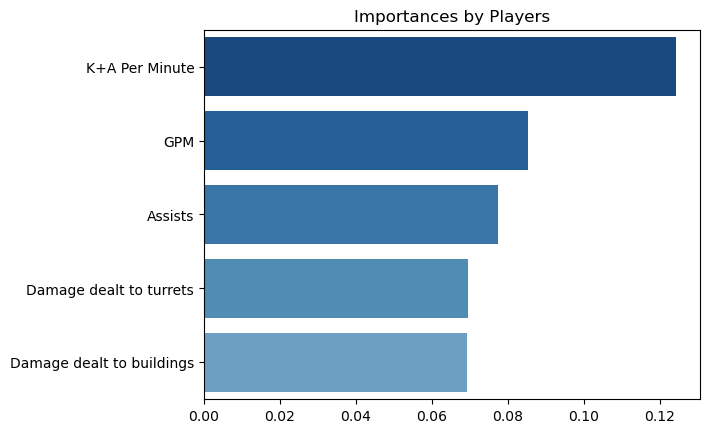

In [280]:
plt.title('Importances by Players')

# 그라데이션 색상 설정
colors = sns.color_palette("Blues", len(df_importances[:10]))
# 색 순서 반전
colors = colors[::-1]


sns.barplot(df_importances[:5].T, orient = 'h', palette = colors)

plt.show()

# 선수 전체에 대해 중요도 빈도수 구하기

In [227]:
df_importances_player_ = pd.DataFrame( index = Team_dict_copy['T1']['Zeus']['model'].feature_names_in_)
df_importances_player_['counts'] = 0

for team in Team_list:
    for player in Team_Player_dict[team]:
        for importance in Team_dict_copy[team][player]['imp']:
            df_importances_player_.loc[importance] += 1


df_importances_player_ = df_importances_player_.sort_values(by = 'counts', ascending=False)
df_importances_player_[:10]

,counts
K+A Per Minute,56
GPM,47
Assists,42
Damage dealt to turrets,39
Damage dealt to buildings,34
Deaths,26
Golds,8
Total Time Spent Dead,8
Kills,7
GD@15,5


## 시각화

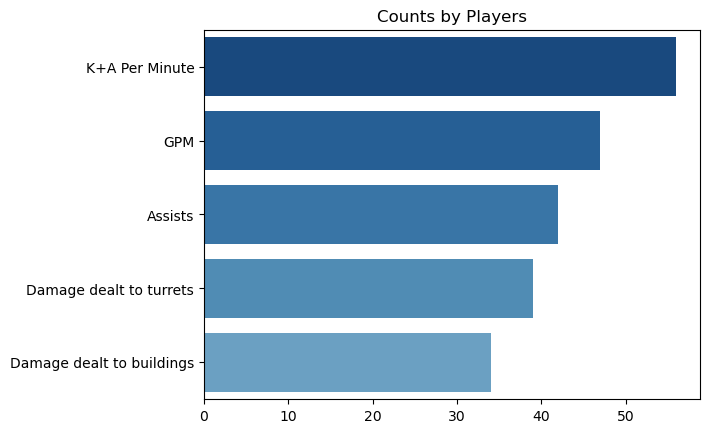

In [281]:
plt.title('Counts by Players')

# 그라데이션 색상 설정
colors = sns.color_palette("Blues", len(df_importances_player_[:10]))
# 색 순서 반전
colors = colors[::-1]


sns.barplot(df_importances_player_[:5].T, orient = 'h', palette = colors)

plt.show()

# 전체 선수 학습기의 정확도 평균 구하기

In [360]:
# 정확도를 합칠 변수
addition = 0

# 선수의 수를 세어 나눌 변수
count = 0

# 팀 내 선수별 학습기에 접근
for team in Team_list:
    for player in Team_Player_dict[team]:
        accuracy = accuracy_score(Player_fit_dict[player]['pred'],Player_fit_dict[player]['y_test'])
        addition += accuracy
        count += 1
        
# 전체 정확도 평균        
acc_avg = addition/count

In [361]:
acc_avg

0.8361108732990882

# 선수별 데이터 예측결과 집계

## 2023 데이터 저장할 딕셔너리들

In [24]:
New_Team_dict = {
    
    'T1': pd.DataFrame(),
    'Gen.G':pd.DataFrame(),
    'Liiv_SB':pd.DataFrame(),
    'Dplus_KIA':pd.DataFrame(),
    'KT':pd.DataFrame(),
    'DRX':pd.DataFrame(),
    'KDF':pd.DataFrame(),
    'NS':pd.DataFrame(),
    'BRO':pd.DataFrame(),
    'HLE':pd.DataFrame()
    
}

In [23]:
## 위에꺼 복사해서 딕셔너리 형태로 새롭게 저장

New_Team_dict_dict = {
    
    'T1': {},
    'Gen.G':{},
    'Liiv_SB': {},
    'Dplus_KIA':{},
    'KT':{},
    'DRX':{},
    'KDF':{},
    'NS':{},
    'BRO':{},
    'HLE':{}
    
}

In [25]:
New_Team_Player_dict = {
    
    "T1": ["Zeus", "Oner", "Faker", "Gumayusi", "Keria"],
    "Gen.G": ["Doran", "Peanut", "Chovy", "Peyz", "Delight"],
    "Dplus_KIA": ["Canna", "Canyon", "ShowMaker", "Deft", "Kellin"],
    "DRX": ["Rascal", "Croco", "Juhan", "FATE", "deokdam", "BeryL"],
    "KT": ["Kiin", "Cuzz", "Bdd", "Aiming", "Lehends"],
    "Liiv_SB": ["Burdol", "Willer", "Clozer", "Teddy", "Kael"],
    "NS": ["DnDn", "Sylvie","FIESTA","vital", "Peter"],
    "HLE": ["kingen", "Clid", "Zeka", "Viper", "Life"],
    "KDF": ["DuDu", "YoungJae", "BuLLDoG", "Taeyoon", "Moham"],
    "BRO": ["Morgan", "UmTi", "Karis", "Hena", "Effort"]
    
}

In [26]:
New_Team_list = ['T1', 'Gen.G', 'Dplus_KIA', 'DRX', 'KT', 'Liiv_SB', 'NS', 'HLE', 'KDF', 'BRO']

In [28]:
# matchlist url

Team_S13_http_dict = {
    
    'T1':'https://gol.gg/teams/team-matchlist/1791/split-ALL/tournament-ALL/',
    'Gen.G':'https://gol.gg/teams/team-matchlist/1792/split-ALL/tournament-ALL/',
    'Dplus_KIA':'https://gol.gg/teams/team-matchlist/1765/split-ALL/tournament-ALL/',
    'DRX':'https://gol.gg/teams/team-matchlist/1766/split-ALL/tournament-ALL/',
    'KT':'https://gol.gg/teams/team-matchlist/1770/split-ALL/tournament-ALL/',
    'Liiv_SB':'https://gol.gg/teams/team-matchlist/1771/split-ALL/tournament-ALL/',
    'NS':'https://gol.gg/teams/team-matchlist/1772/split-ALL/tournament-ALL/',
    'HLE':'https://gol.gg/teams/team-matchlist/1769/split-ALL/tournament-ALL/',
    'KDF':'https://gol.gg/teams/team-matchlist/1764/split-ALL/tournament-ALL/',
    'BRO':'https://gol.gg/teams/team-matchlist/1767/split-ALL/tournament-ALL/'
    
}

In [29]:
# 각 팀의 result 이름을 담은 딕셔너리
# 표기가 다름

Team_result_dict13={'T1':'T1',
                  'Gen.G':'GEN',
                  'Dplus_KIA':'DK',
                  'DRX':'DRX',
                  'KT':'KT',
                  'Liiv_SB':'LSB',
                  'NS':'NS',
                  'HLE':'HLE',
                  'KDF':'KDF',
                  'BRO':'BRO'}

## 2023 경기의 입력 데이터 정제 및 저장 함수

In [84]:
## 함수 제작
## 2023년의 선수들의 데이터를 selenium을 통해 csv로 받아서 
def DataCollector13(TeamName):
    
    driver = undetected_chromedriver.Chrome()
    # T1의 모든 시즌 데이터 있는 웹사이트
    url = Team_S13_http_dict[TeamName]

    driver.get(url)

    time.sleep(1)

    # 버튼 클릭
    # button = driver.find_element(By.ID, 'export-btn')
    button = driver.find_element(By.CLASS_NAME, 'btn.btn-gol')
    button.click()

    time.sleep(0.5)

    # 클립보드 복사
    copied_df = pd.read_clipboard(sep='\t')

    # 데이터 정제
    copied_df = copied_df.reset_index()
    copied_df = copied_df.rename(columns = pd.Series(copied_df.iloc[0,:]))[1:]

    driver.close()
    
    
    TeamName_ = Team_result_dict13[TeamName]


    # 데이터 정제 및 변수로 인덱싱
    result_gameclass_df = copied_df.iloc[:,[0,-1]]

    # 새로운 칼럼 생성(복사)
    result_gameclass_df['Result Score'] = result_gameclass_df[f'{TeamName_} Result']
    result_gameclass_df['Tournament Score'] = result_gameclass_df['Tournament']

    # 승패를 숫자로 변경
    for i in range(result_gameclass_df.__len__()):
        result_gameclass_df['Result Score'].iloc[i] = np.where(result_gameclass_df[f'{TeamName_} Result'].iloc[i] == 'LOSS', 0, 1)


    ## 선수별 데이터 담기


    # url = Team_S12_http_dict[TeamName]

    headers = {'Accept-Language': 'ko_KR,en;q=0.8',
               'User-Agent': ('Mozilla/5.0 (Linux; Android 6.0; Nexus 5 Build/MRA58N) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/78.0.3904.70 Mobile Safari/537.36')}

    ## request 모듈

    html = requests.get(url, headers = headers)
    soup = BeautifulSoup(html.text)  # html.text 로 넣어야됨


    # td 먼저 분리
    td_tags = soup.find_all('td', class_='text-center')


    # a 태그의 href 길이를 보고 분리
    # href는 팀의 경기 하나하나의 링크임.
    # links에 각 링크들을 저장
    links = []
    for td in td_tags:
        a_tag = td.find('a', href=True)
        if a_tag:
            if len(a_tag['href']) == 30:
                links.append(a_tag['href'])



    # undetected_chromedriver로 크롬 열기            
    driver = undetected_chromedriver.Chrome()

    
    # 데이터 담을 그릇
    Team_Player_list = New_Team_Player_dict[TeamName]
    Team_local_dict = New_Team_dict[TeamName]

    # 밑에 for문 돌리기 위한 count 설정
    count = 0
    
    # 파일저장할 경로 설정
    # os.chdir('C:/Users/asd11/Project2/Game_data/')

    # for문으로 url에 해당하는 웹페이지로 이동
    for link in links:
        url = f'https://gol.gg{link[2:-6]}-fullstats/'

        driver.get(url)

        time.sleep(2)

        # 버튼 클릭
        button = driver.find_element(By.ID, 'export-btn')
        
        time.sleep(1)
        
        button.click()

        time.sleep(1)

        # 클립보드 복사
        copied_df = pd.read_clipboard(sep='\t')

        # 복사한 데이터프레임 전치
        copied_df = copied_df.T

        # index를 칼럼으로 빼고
        # Player 칼럼을 index로 함.
        # CS in Enemy Jungle, Shutdown bounty collected, Shutdown bounty lost, KDA 칼럼 삭제
        # Champion, 라인 까지 칼럼에서 제외

        df = copied_df.reset_index(names='Champion')
        df = df.set_index('Player')
        df = df.drop(['CS in Enemy Jungle', 'Shutdown bounty collected', 'Shutdown bounty lost', 'KDA', 'Champion','Role'], axis=1)
        df['Solo kills'].fillna(0,inplace=True)

        

        ## % 기호가 있는 값을 가지는 칼럼에 대해 실수로 처리
        li = ['GOLD%', 'KP%', 'DMG%', 'VS%']
        for i in li:
            for j in range(len(df[i])):
                df[i][j] = float(df[i][j][:-1])
                # df.loc[j, i] = float(df.loc[j, i][:-1])

        

        # 게임데이터 집계   
        # 여기서 부터 더하는 이유는 result_gameclass_df의 인덱스가 1부터 시작하기 때문임
        count += 1
        for i in df.index:  #i는 해당게임의 플레이어 이름

            if i in Team_Player_list:
                Player_df = pd.DataFrame(df.loc[i]).T
                Player_df['Result Score'] = result_gameclass_df.loc[count]['Result Score']
                Team_local_dict = pd.concat([Team_local_dict, Player_df], axis=0)
            
        # 해당경기에 대해 선수데이터를 다 저장했으면,
        Team_local_dict.to_csv(f'{TeamName+"_S13_Game_"+str(count)}.csv')
        
        ## 이걸 했어야 함
        Team_local_dict = pd.DataFrame()
        
        
    
    # 워킹디렉토리 설정
    # os.chdir('C:/Users/user/Desktop/Project2_Data/Player_data/')
    
#     for playername in Team_Player_list:
#         Team_local_dict[playername] = Team_local_dict[playername].astype(float)  
#         # 이거 해야 데이터프레임의 숫자들이 float으로 바뀜
    
    
    
    
    driver.close()
    

In [85]:
# 경고메세지 무시
warnings.filterwarnings("ignore")

for team in New_Team_list:
    DataCollector13(team)
    
# 경고메세지 무시 해제
warnings.filterwarnings("default")

# csv파일 불러서 겹치는 부분 빼는 함수<br>: 데이터 불러오는 과정에서 실수해서 필요한 작업이었음

In [357]:
# 각 팀의 파일개수
End_dict = {
    
    'T1': 73,
    'Gen.G':74,
    'Liiv_SB': 51,
    'Dplus_KIA':44,
    'KT':60,
    'DRX':44,
    'KDF':45,
    'NS':42,
    'BRO':44,
    'HLE':57
    
}

In [31]:
New_Team_list

['T1', 'Gen.G', 'Dplus_KIA', 'DRX', 'KT', 'Liiv_SB', 'NS', 'HLE', 'KDF', 'BRO']

In [184]:
os.chdir('C:\\Users\\user\\Desktop\\Project2_Data\\Game_data\\')
for team in New_Team_list:
    for i in range(1,End_dict[team]+1):
        if i == 1:
            
            df = pd.read_csv(f"C:\\Users\\user\\Desktop\\Project2_Data\\Game_data_13\\{team}_S13_Game_{i}.csv")
            df.to_csv(f'{team}_S13_{i}.csv')
            
        else :
            # 첫 번째 CSV 파일 로드
            df1 = pd.read_csv(f"C:\\Users\\user\\Desktop\\Project2_Data\\Game_data_13\\{team}_S13_Game_{i}.csv")

            # 두 번째 CSV 파일 로드
            df2 = pd.read_csv(f"C:\\Users\\user\\Desktop\\Project2_Data\\Game_data_13\\{team}_S13_Game_{i-1}.csv")

            # 겹치는 부분 제거
            df_result = pd.merge(df1, df2, how='outer', indicator=True).query('_merge=="left_only"').drop('_merge', axis=1)

            # 결과 저장
            df_result.to_csv(f'{team}_S13_{i}.csv')

## 최종 승패예측

In [355]:
## 한 경기에서 선수별 예측값을 종합하여 평균을 내는 함수
## 리턴은 선수들의 예측값 평균과 실제 승패여부(0,1)
def Ensemble_Avg(df):
    X = df.iloc[:,:-1]
    y = df.iloc[:,-1]
    
    ens_avg = 0
    
    # 선수 숫자
    count = 0
    
    for player in df.index: # player는 플레이어 이름
        try:
            pred = Player_fit_dict[player]['model'].predict(X.loc[[player]])
            ens_avg += pred.astype(float)
            count += 1
        except:
            pred  = 0.5
            ens_avg += pred
            count += 1
            
    return ens_avg/count, y.loc[player]

In [359]:
# 전체 팀에 대해 2023년 새롭게 구성된 선수들에 대한 최종 예측값의 정확도
final_df = pd.DataFrame(columns = ['pred','real'])

for team in New_Team_list:
    final_df = pd.DataFrame(columns = ['pred','real'])

    for i in range(1,End_dict[team]+1):
        df = pd.read_csv(f"C:\\Users\\user\\Desktop\\Project2_Data\\Game_data\\{team}_S13_{i}.csv", header = 0, index_col= 1).iloc[:,1:]
        df.index.name = None
        x, y = Ensemble_Avg(df)
        x = x[0]
        if x >= 0.5:
            x = 1
        else:
            x = 0

        x = int(x)    
        final_df = pd.concat([final_df, pd.DataFrame([[x,y]],columns = ['pred','real'])], axis = 0)
    print(team,end = '\t')
    print(accuracy_score(final_df['real'].astype(int), final_df['pred'].astype(int)))


T1	0.8904109589041096
Gen.G	0.7972972972972973
Dplus_KIA	0.9545454545454546
DRX	0.9772727272727273
KT	0.9333333333333333
Liiv_SB	0.9215686274509803
NS	0.9523809523809523
HLE	0.9298245614035088
KDF	0.8666666666666667
BRO	0.9318181818181818
